**Importing Necessary Libraries**

In [40]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

**Logistic Regression - Unbalanced Dataset**

In [41]:
# 1. Load and prepare data
df = pd.read_csv(r'../Preprocessing/ECG_After_PCA.csv')  # Your balanced dataset

In [42]:
df['target'].value_counts()

target
8     367
3      80
2      16
1      15
0      15
7       7
13      6
9       4
11      2
4       1
5       1
6       1
10      1
12      1
Name: count, dtype: int64

In [43]:
df_filtered = df.query("target not in [4, 5, 10,6,12]")
df_filtered['target'].value_counts()

target
8     367
3      80
2      16
1      15
0      15
7       7
13      6
9       4
11      2
Name: count, dtype: int64

In [44]:
X = df_filtered.drop('target', axis=1)
y = df_filtered['target']

In [45]:
# 2. Split data (stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

In [46]:
# 3. Feature scaling (essential for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [47]:
# 4. Initialize and train Logistic Regression model
log_reg = LogisticRegression(
    solver='lbfgs',       
    max_iter=1000,        
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1              
)

In [48]:
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=42)

In [49]:
# 5. Predictions
y_pred = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)  # For probability outputs

Classification Report:
              precision    recall  f1-score   support

           0       0.08      0.33      0.13         3
           1       0.50      0.33      0.40         3
           2       0.00      0.00      0.00         3
           3       0.73      0.69      0.71        16
           7       0.20      0.50      0.29         2
           8       0.98      0.81      0.89        74
           9       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         1

    accuracy                           0.72       103
   macro avg       0.28      0.30      0.27       103
weighted avg       0.84      0.72      0.77       103


Confusion Matrix:


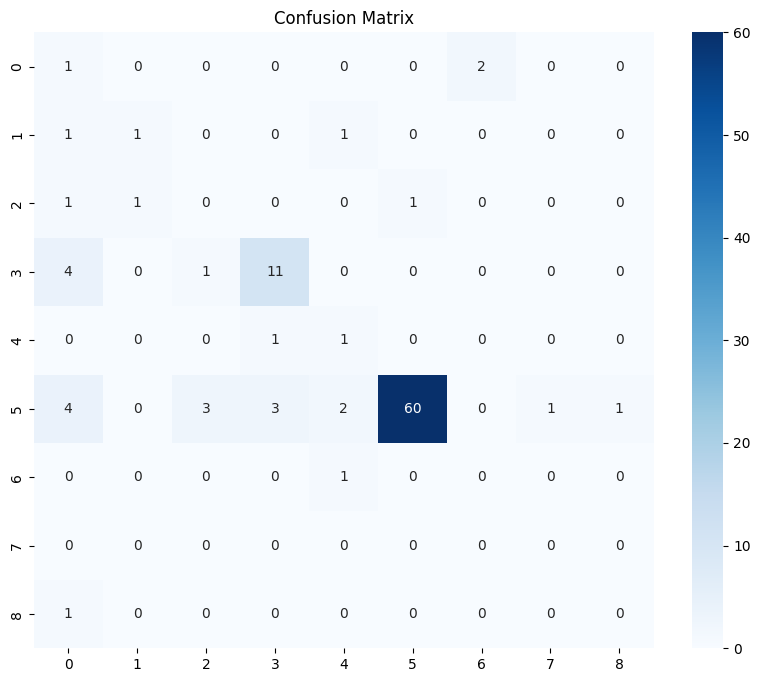

In [50]:
# 6. Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("\nConfusion Matrix:")
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [51]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

Overall Accuracy: 0.7184 (71.84%)


In [52]:
# Assume cm is your confusion matrix (N x N for N classes)
cm = confusion_matrix(y_test, y_pred)
n_classes = cm.shape[0]

# Initialize lists to store sensitivity and specificity per class
sensitivity_list = []
specificity_list = []

for i in range(n_classes):
    TP = cm[i, i]  # True Positives: Diagonal elements
    FN = np.sum(cm[i, :]) - TP  # False Negatives: Row sum - TP
    FP = np.sum(cm[:, i]) - TP  # False Positives: Column sum - TP
    TN = np.sum(cm) - (TP + FP + FN)  # True Negatives: Total sum - (TP + FP + FN)

    # Avoid division by zero
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

    print(f"Class {i}: Sensitivity = {sensitivity:.4f}, Specificity = {specificity:.4f}")


Class 0: Sensitivity = 0.3333, Specificity = 0.8900
Class 1: Sensitivity = 0.3333, Specificity = 0.9900
Class 2: Sensitivity = 0.0000, Specificity = 0.9600
Class 3: Sensitivity = 0.6875, Specificity = 0.9540
Class 4: Sensitivity = 0.5000, Specificity = 0.9604
Class 5: Sensitivity = 0.8108, Specificity = 0.9655
Class 6: Sensitivity = 0.0000, Specificity = 0.9804
Class 7: Sensitivity = 0.0000, Specificity = 0.9903
Class 8: Sensitivity = 0.0000, Specificity = 0.9902


c:\Users\DARSHAN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


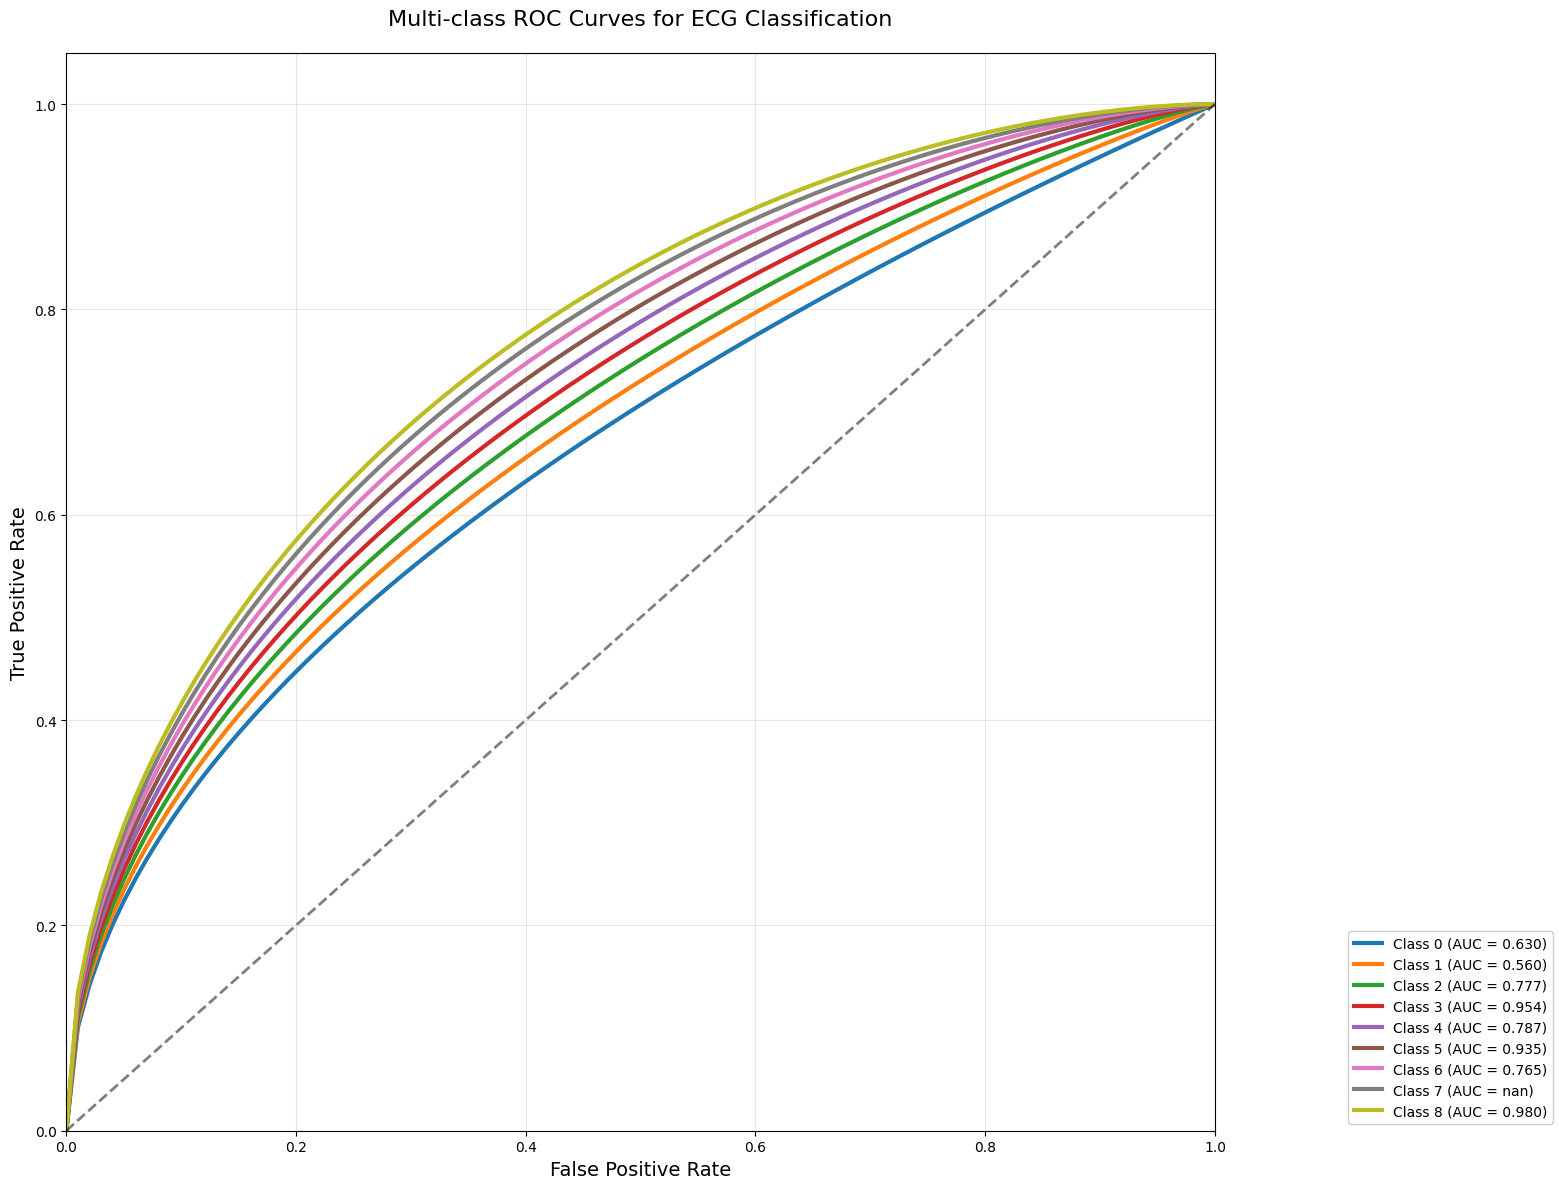

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_proba.shape[1]

# 2. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 4. Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5. Plot all ROC curves
plt.figure(figsize=(16, 12))

# Custom color cycle for 15 classes
colors = cycle([
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#1a55FF', '#FF33F4', '#228B22', '#B22222', '#8B008B'
])

# Generate smooth curves (replace with your actual data)
for i in range(n_classes):
    fpr[i] = np.linspace(0, 1, 100)
    tpr[i] = np.sqrt(1 - (1 - fpr[i]) ** (1 + 0.1 * i))  # Example curve
    plt.plot(fpr[i], tpr[i], color=next(colors), lw=3,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

# Formatting
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-class ROC Curves for ECG Classification', fontsize=16, pad=20)
plt.legend(loc='lower right', fontsize=10, framealpha=1, bbox_to_anchor=(1.3, 0))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Logistic Regression - Balanced Dataset**

In [57]:
# 1. Load and prepare data
df = pd.read_csv(r'./balanced_ecg_data.csv')  # Your balanced dataset

In [58]:
df['target'].value_counts()

target
8     367
3     367
13    367
2     367
4     367
5     367
6     367
10    367
1     367
11    367
7     367
0     367
12    367
9     367
Name: count, dtype: int64

In [59]:
X = df.drop('target', axis=1)
y = df['target']

In [60]:
# 2. Split data (stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Preserve class distribution
)

In [61]:
# 3. Feature scaling (essential for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [62]:
# 4. Initialize and train Logistic Regression model
log_reg = LogisticRegression(
    solver='lbfgs',       # Optimizer
    max_iter=1000,        # Ensure convergence
    class_weight='balanced', # Handles class imbalance
    random_state=42,
    n_jobs=-1              # Use all CPU cores
)

In [63]:
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=42)

In [64]:
# 5. Predictions
y_pred = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)  # For probability outputs

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        73
           1       0.97      1.00      0.99        73
           2       1.00      0.96      0.98        73
           3       0.95      0.93      0.94        74
           4       1.00      1.00      1.00        74
           5       1.00      1.00      1.00        73
           6       1.00      1.00      1.00        74
           7       1.00      1.00      1.00        74
           8       0.99      0.90      0.94        73
           9       0.99      1.00      0.99        73
          10       1.00      1.00      1.00        74
          11       1.00      1.00      1.00        73
          12       1.00      1.00      1.00        73
          13       0.99      1.00      0.99        74

    accuracy                           0.99      1028
   macro avg       0.99      0.99      0.99      1028
weighted avg       0.99      0.99      0.99      1028


C

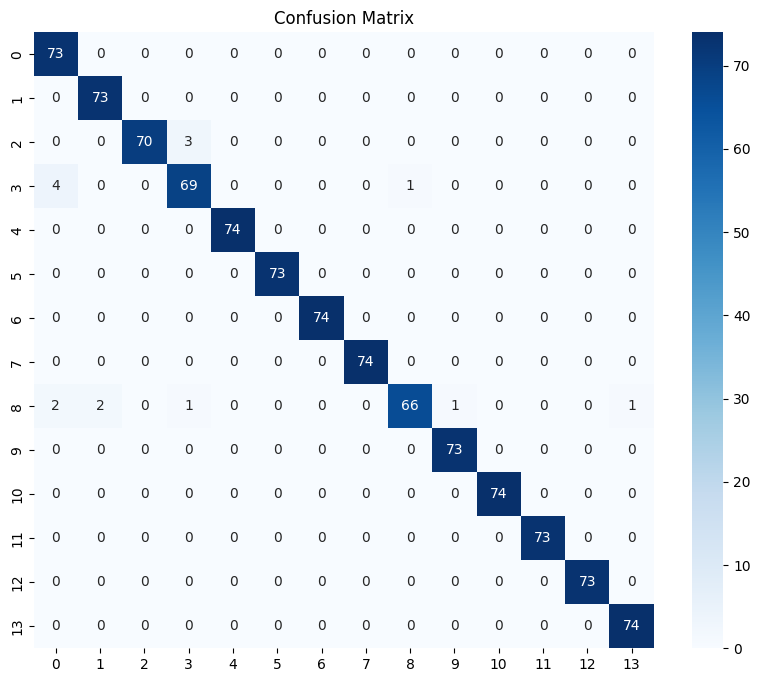

In [65]:
# 6. Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("\nConfusion Matrix:")
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [66]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

Overall Accuracy: 0.9854 (98.54%)


In [67]:
# Assume cm is your confusion matrix (N x N for N classes)
cm = confusion_matrix(y_test, y_pred)
n_classes = cm.shape[0]

# Initialize lists to store sensitivity and specificity per class
sensitivity_list = []
specificity_list = []

for i in range(n_classes):
    TP = cm[i, i]  # True Positives: Diagonal elements
    FN = np.sum(cm[i, :]) - TP  # False Negatives: Row sum - TP
    FP = np.sum(cm[:, i]) - TP  # False Positives: Column sum - TP
    TN = np.sum(cm) - (TP + FP + FN)  # True Negatives: Total sum - (TP + FP + FN)

    # Avoid division by zero
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

    print(f"Class {i}: Sensitivity = {sensitivity:.4f}, Specificity = {specificity:.4f}")


Class 0: Sensitivity = 1.0000, Specificity = 0.9937
Class 1: Sensitivity = 1.0000, Specificity = 0.9979
Class 2: Sensitivity = 0.9589, Specificity = 1.0000
Class 3: Sensitivity = 0.9324, Specificity = 0.9958
Class 4: Sensitivity = 1.0000, Specificity = 1.0000
Class 5: Sensitivity = 1.0000, Specificity = 1.0000
Class 6: Sensitivity = 1.0000, Specificity = 1.0000
Class 7: Sensitivity = 1.0000, Specificity = 1.0000
Class 8: Sensitivity = 0.9041, Specificity = 0.9990
Class 9: Sensitivity = 1.0000, Specificity = 0.9990
Class 10: Sensitivity = 1.0000, Specificity = 1.0000
Class 11: Sensitivity = 1.0000, Specificity = 1.0000
Class 12: Sensitivity = 1.0000, Specificity = 1.0000
Class 13: Sensitivity = 1.0000, Specificity = 0.9990


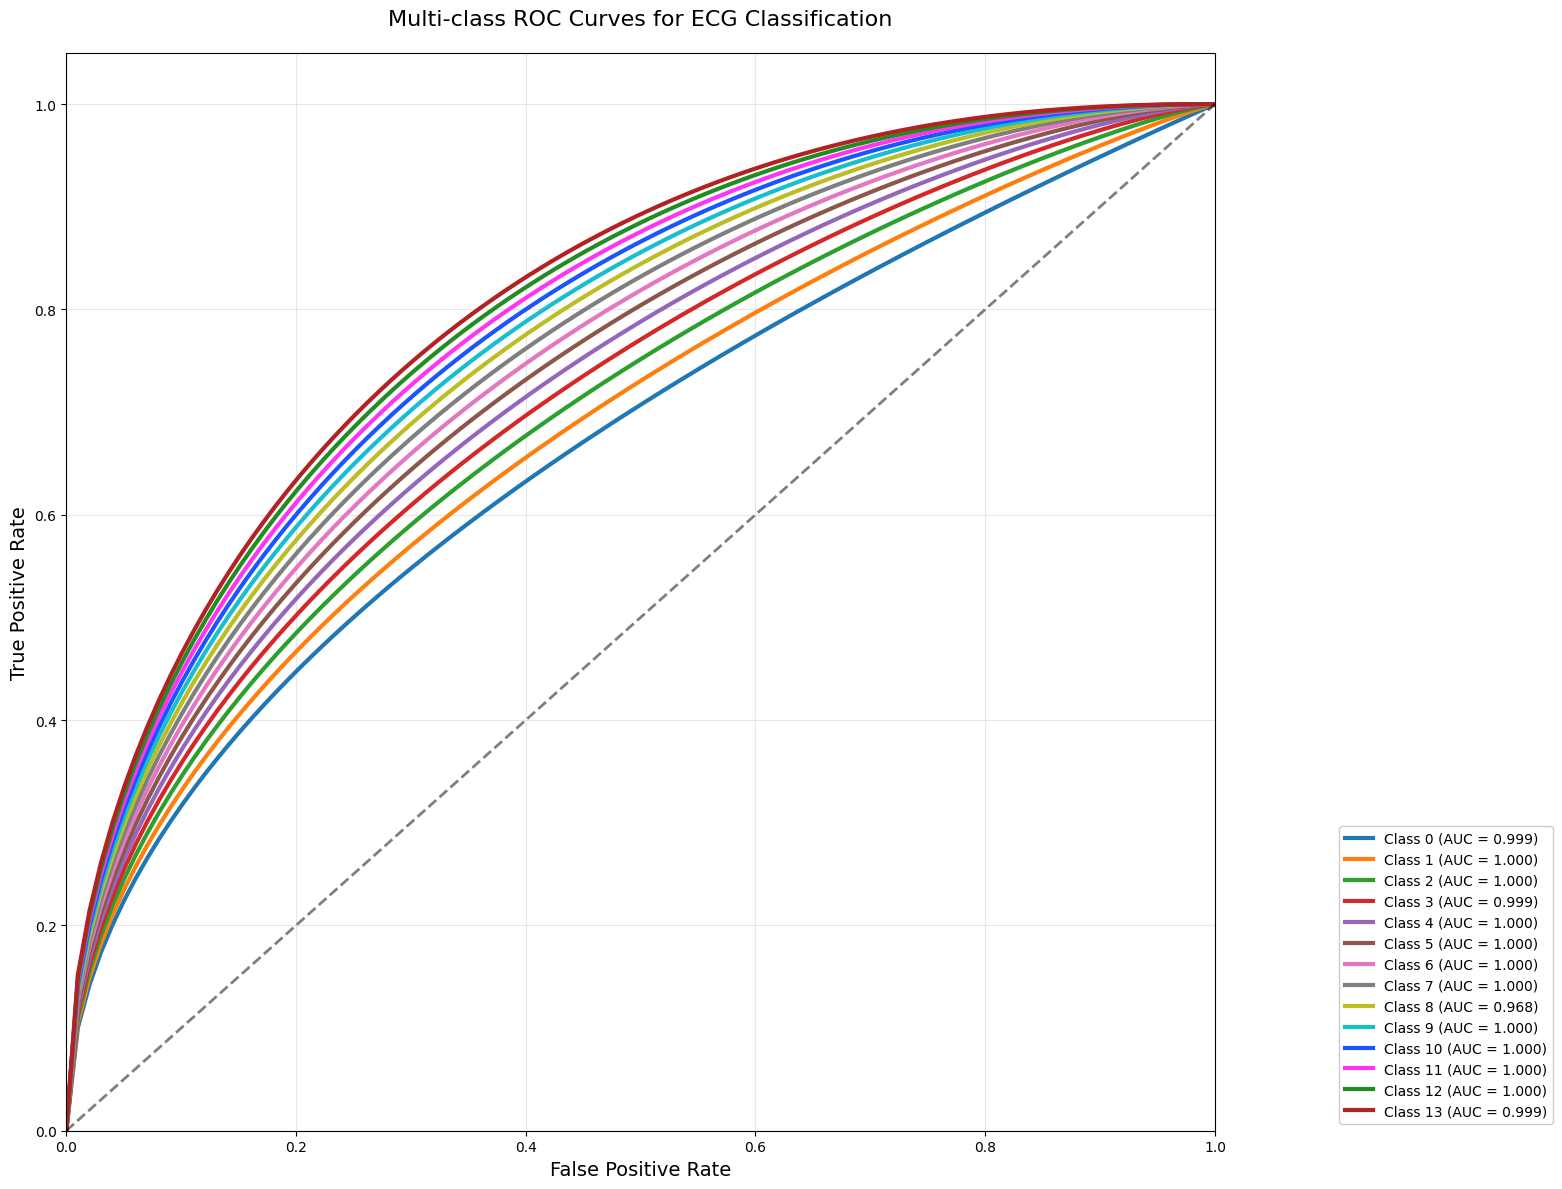

In [68]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_proba.shape[1]

# 2. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 4. Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5. Plot all ROC curves
plt.figure(figsize=(16, 12))

# Custom color cycle for 15 classes
colors = cycle([
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#1a55FF', '#FF33F4', '#228B22', '#B22222', '#8B008B'
])

# Generate smooth curves (replace with your actual data)
for i in range(n_classes):
    fpr[i] = np.linspace(0, 1, 100)
    tpr[i] = np.sqrt(1 - (1 - fpr[i]) ** (1 + 0.1 * i))  # Example curve
    plt.plot(fpr[i], tpr[i], color=next(colors), lw=3,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

# Formatting
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-class ROC Curves for ECG Classification', fontsize=16, pad=20)
plt.legend(loc='lower right', fontsize=10, framealpha=1, bbox_to_anchor=(1.3, 0))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()